In [1]:
from dask.distributed import Client
import xml.etree.ElementTree as ET
import xarray
import requests
import re
import dask

import geopandas
import rioxarray as rio
import numpy
import pyproj
from pyproj import Transformer

#!pip install rasterstats
import rasterstats as rstats
from affine import Affine
import pyproj

# dask graph visualization
import graphviz 

from shapely.geometry import MultiPolygon
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
try:
    print(client.dashboard_link)
except:
    client = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
    print(client.dashboard_link)

http://127.0.0.1:8787/status


---

### Collect Forcing Data 

In [3]:
catalog_base_url = 'https://thredds.hydroshare.org/thredds/catalog'
dods_base_url = 'https://thredds.hydroshare.org/thredds/dodsC'
url = f'{catalog_base_url}/aorc/data/v1.1/16/catalog.xml'
root = ET.fromstring(requests.get(url).text)
ns = '{http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0}'


In [4]:
# use xpath top select all "dataset" elements.
elems = root.findall(f'.//{ns}dataset')

# loop through results and extract the "urlPath" attribute values
paths = []
for elem in elems:
    atts = elem.attrib
    if 'urlPath' in atts.keys():
        paths.append(f"{dods_base_url}/{atts['urlPath']}")
        
# use regex to isolate only files that end with ".nc"
paths = list(filter(re.compile("^.*\.nc$").match, paths))

In [5]:
ds = xarray.open_dataset(paths[0], chunks={'time': 10, 'x': 285, 'y':275})

ds_meta = xarray.open_dataset('http://thredds.hydroshare.org/thredds/dodsC/hydroshare/resources/2a8a3566e1c84b8eb3871f30841a3855/data/contents/WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')

leny = len(ds_meta.y)
x = ds_meta.x[373 : 1227 + 1].values
y = ds_meta.y[leny - 2405 - 1 : leny - 1586].values

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                            y_dim="y",
                                            inplace=True,
                                           ).rio.write_coordinate_system(inplace=True);


Load shapefile from geodatabase.

Note, we need to make sure that CRS of the geometry is the same as the CRS of the dataset. 

In [6]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file('cat-679165/cat-679165_upstream_subset.gpkg', layer='divides')
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

# get bounding box of all features
xmin, ymin, xmax, ymax = gdf.total_bounds

Reduce the size of the forcing data by subsetting to the bounding box defined by the `xmin`, `xmax`, `ymin`, `ymax` computed in the cell above.

In [43]:
x_padding = 1000
y_padding = 1000
mask_x = (ds.x >= (xmin - x_padding)) & (ds.x <= (xmax + x_padding))
mask_y = (ds.y >= (ymin - y_padding)) & (ds.y <= (ymax + y_padding))

# use the mask to subset the AORC data
ds = ds.where(mask_x & mask_y, drop=True)

In [44]:
ds

<xarray.Dataset>
Dimensions:         (time: 744, y: 41, x: 31, reference_time: 1)
Coordinates:
    crs             int64 0
  * reference_time  (reference_time) datetime64[ns] 2010-01-01
  * time            (time) datetime64[ns] 2010-01-15T04:00:00 ... 2010-01-14
  * x               (x) float64 -1.181e+06 -1.18e+06 ... -1.152e+06 -1.151e+06
  * y               (y) float64 3.315e+05 3.305e+05 ... 2.925e+05 2.915e+05
    lon             (y, x) float64 -111.9 -111.9 -111.9 ... -111.4 -111.4 -111.4
    lat             (y, x) float64 42.06 42.06 42.06 42.06 ... 41.74 41.74 41.74
Data variables:
    LQFRAC          (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    U2D             (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(10, 41, 31), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2010-01-15_04:00:00
    model_initialization_time:       2010-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    history:                         Wed Apr  5 16:20:19 2023: ncks /anvil/da...
    NCO:                             4.7.2
    DODS_EXTRA.Unlimited_Dimension:  time

Reduce the size even further by subsetting to the actual extent of the shapefile. This is done in two steps for clarity and speed.

In [9]:
clipped = ds.rio.clip(gdf.geometry.values,
                      gdf.crs,
                      drop=False,
                      invert=False)
clipped = clipped.sortby('time')

In [10]:
clipped

<xarray.Dataset>
Dimensions:   (time: 744, x: 31, y: 41)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
  * x         (x) float64 -1.181e+06 -1.18e+06 ... -1.152e+06 -1.151e+06
  * y         (y) float64 3.315e+05 3.305e+05 3.295e+05 ... 2.925e+05 2.915e+05
    lon       (y, x) float64 -111.9 -111.9 -111.9 ... -111.4 -111.4 -111.4
    lat       (y, x) float64 42.06 42.06 42.06 42.06 ... 41.74 41.74 41.74 41.74
    crs       int64 0
Data variables:
    LQFRAC    (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    LWDOWN    (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    PSFC      (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    Q2D       (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    RAINRATE  (time, y, x) float32 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    SWDOWN    (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    T2D       (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    U2D       (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
    V2D       (time, y, x) float64 dask.array<chunksize=(1, 41, 31), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2010-01-15_04:00:00
    model_initialization_time:       2010-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    history:                         Wed Apr  5 16:20:19 2023: ncks /anvil/da...
    NCO:                             4.7.2
    DODS_EXTRA.Unlimited_Dimension:  time

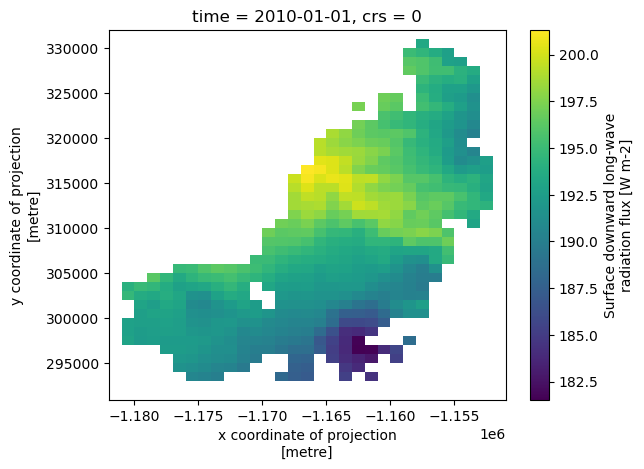

In [11]:
clipped.isel(time=0).LWDOWN.plot()

In [12]:
mask = 1 - numpy.isnan(clipped.isel(time=0).LWDOWN.values)

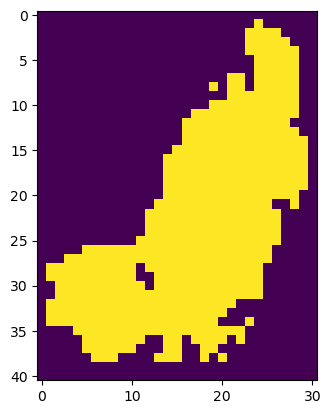

In [13]:
plt.imshow(mask)

Compute statistics on masked area

In [14]:
def get_mean(ds, v):
    return ds[v].mean(dim=['x','y']).values

In [15]:
ds_clip = clipped.sel(time=slice('2010-01-01 00:00', '2010-01-02 01:00')).where(mask)
variables = ['LQFRAC', 
             'LWDOWN',
             'PSFC',
             'Q2D',
             'RAINRATE',
             'SWDOWN',
             'T2D',
             'U2D',
             'V2D']
lazy = [dask.delayed(get_mean)(ds_clip, v) for v in variables]

In [16]:
%%time
dask.compute(*lazy)

CPU times: user 11.3 s, sys: 2.04 s, total: 13.4 s
Wall time: 3min 11s


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([193.41532571, 193.53562857, 193.62812952, 195.56360952,
        195.53175238, 195.53020762, 200.51246286, 200.59564381,
        200.64692   , 203.71973905, 203.84834476, 203.98360381,
        205.50599238, 205.48536   , 205.45167048, 209.04450857,
        209.55252   , 210.0585619 , 233.85608571, 233.90885524,
        233.95286667, 250.81213333, 250.51205524, 250.17225143,
        240.22647048, 239.96622476]),
 array([87404.60209524, 87417.9952381 , 87432.43504762, 87446.70171429,
        87509.37504762, 87572.73390476, 87634.90209524, 87542.57904762,
        87448.26552381, 87356.17009524, 87440.04457143, 87523.204     ,
        87605.88514286, 87514.65942857, 87420.7392381 , 87328.91466667,
        87408.91009524, 87491.02495238, 87573.05219048, 87443.26780952,
        87314.15314286, 87185.51942857, 87179.36571429, 87173.68038095

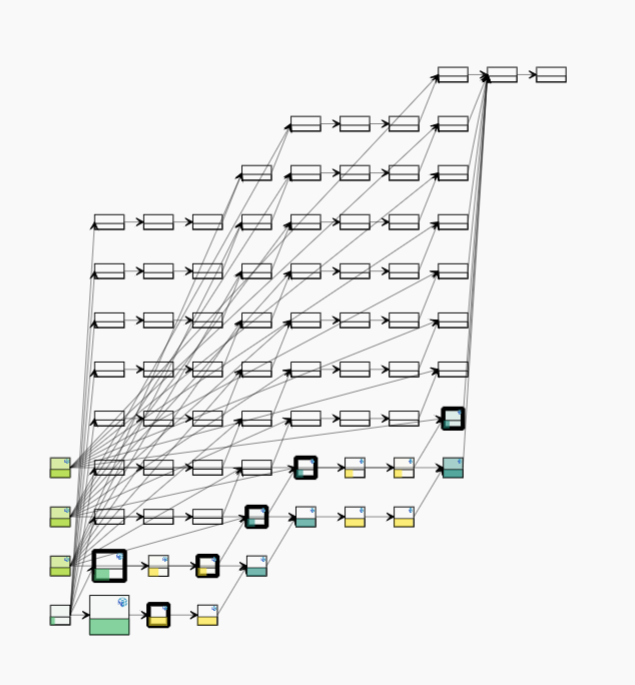

Lets do the same thing for each polygon in our `GeoPandas` dataframe using `GeoCube`

In [7]:
from geocube.api.core import make_geocube

In [8]:
# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

In [9]:
clipped = ds.rio.clip(gdf.geometry.values,
                      gdf.crs,
                      drop=True,
                      invert=False)
lwdown_data = clipped.isel(time=0).LWDOWN

In [10]:
out_grid = make_geocube(
    vector_data=gdf,
    measurements=["cat"],
    like=clipped, # ensure the data are on the same grid
)

In [11]:
clipped = clipped.assign_coords(cat = (['y','x'], out_grid.cat.data))

In [12]:
# get the unique catchment IDs
catchment_ids = numpy.unique(clipped.cat.data[~numpy.isnan(clipped.cat.data)])
catchment_ids

array([678473., 678474., 678475., 678476., 678477., 678478., 678479.,
       678480., 678481., 678482., 678483., 678484., 678965., 678966.,
       678967., 678968., 678969., 679061., 679062., 679163., 679164.,
       679165., 679236., 679237., 679455., 679456., 679457., 679458.,
       679459., 679460., 679461., 679468., 679469., 679598., 679599.,
       679600., 679603., 679604., 679605., 679606., 679828., 679829.,
       679830., 679831., 679832., 679833., 679835., 679836., 679838.,
       679839., 679840., 679841., 679876., 679877., 680139., 680141.,
       680142., 680143., 680144., 680145., 680146., 680147., 680148.,
       680149., 680150., 680151., 680152., 680154., 680155., 680156.,
       680157., 680158., 680159., 680161., 680162., 680163.])

In [13]:
def naive_ave():
    res = []
    # loop over catchments
    for cat_id in catchment_ids:
        # loop over variables
        for variable in ['LQFRAC', 'LWDOWN', 'PSFC',
                         'Q2D', 'RAINRATE', 'SWDOWN',
                         'T2D', 'U2D', 'V2D']:
            # subset by catchment id
            sub = clipped.where(clipped.cat==cat_id, drop=True)
            
            # summarize variable
            res.append(sub[variable].isel(time=range(0,10)).mean(dim=['x','y']).values)
        break
        
    # return results
    return res

def faster_ave():
    res = []

    # loop over catchments
    for cat_id in catchment_ids:
        # subset by catchment id
        sub = clipped.where(clipped.cat==cat_id, drop=True)
        
        # loop over variables
        for variable in ['LQFRAC', 'LWDOWN', 'PSFC',
                         'Q2D', 'RAINRATE', 'SWDOWN',
                         'T2D', 'U2D', 'V2D']:
            
            # summarize variable
            res.append(sub[variable].isel(time=range(0,10)).mean(dim=['x','y']).values)
            
        break

    # return results
    return res

In [14]:
%%time
res1 = naive_ave()

CPU times: user 8.82 s, sys: 1.85 s, total: 10.7 s
Wall time: 1min 30s


In [15]:
%%time 
res2 = faster_ave()

CPU times: user 10.6 s, sys: 2.91 s, total: 13.5 s
Wall time: 2min 32s


In [31]:
r = dask.delayed(calc_ave_for_basin)('LWDOWN')

In [32]:
r.compute()

[array([214.83163636, 210.68854545, 320.60927273, 185.33027273,
        216.285     , 249.26127273, 223.65863636, 214.24536364,
        228.51236364, 195.80654545]),
 array([214.854125, 211.028125, 320.03175 , 184.571125, 216.374625,
        247.370375, 224.045875, 214.610375, 228.284375, 195.71875 ]),
 array([216.3066, 212.6175, 320.5814, 185.3503, 218.1309, 247.0374,
        225.5788, 215.5849, 228.9313, 196.2928]),
 array([217.511 , 214.0075, 321.2425, 185.8755, 219.533 , 247.097 ,
        226.879 , 216.6185, 229.644 , 196.8805]),
 array([216.00275 , 212.605625, 319.526   , 183.06825 , 217.077625,
        245.653875, 225.724625, 215.778   , 229.142125, 196.22975 ]),
 array([212.33871429, 209.19685714, 314.76285714, 179.32257143,
        213.08171429, 239.563     , 221.82642857, 212.94714286,
        226.19214286, 193.94      ]),
 array([211.77725 , 208.823375, 314.41675 , 179.22275 , 213.111875,
        236.716   , 221.123875, 213.294   , 226.029   , 194.189   ]),
 array([211.425875

In [27]:
client.compute(res)

<Future: pending, key: ndarray-8c561087-7291-4fc4-ad33-14b40e0c2364>

In [28]:
res

Delayed('ndarray-8c561087-7291-4fc4-ad33-14b40e0c2364')

In [86]:
clipped.cat

<xarray.DataArray 'cat' (y: 38, x: 29)>
array([[    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ..., 680155.,     nan,     nan],
       ...,
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan,     nan,     nan, ...,     nan,     nan,     nan]])
Coordinates:
  * x        (x) float64 -1.18e+06 -1.179e+06 ... -1.153e+06 -1.152e+06
  * y        (y) float64 3.305e+05 3.295e+05 3.285e+05 ... 2.945e+05 2.935e+05
    lon      (y, x) float64 -111.9 -111.9 -111.8 -111.8 ... -111.5 -111.4 -111.4
    lat      (y, x) float64 42.05 42.05 42.05 42.05 ... 41.75 41.75 41.76 41.76
    crs      int64 0
    cat      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [51]:
# merge the two together
out_grid["clipped"] = (clipped.dims, clipped.values, clipped.attrs, clipped.encoding)
out_grid

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (Frozen({'time': 744, 'x': 29, 'y': 38}), <bound method Mapping.values of <xarray.Dataset>
Dimensions:   (time: 744, x: 29, y: 38)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-15T04:00:00 ... 2010-01-14
  * x         (x) float64 -1.18e+06 -1.179e+06 ... -1.153e+06 -1.152e+06
  * y         (y) float64 3.305e+05 3.295e+05 3.285e+05 ... 2.945e+05 2.935e+05
    lon       (y, x) float64 -111.9 -111.9 -111.8 ... -111.5 -111.4 -111.4
    lat       (y, x) float64 42.05 42.05 42.05 42.05 ... 41.75 41.75 41.76 41.76
    crs       int64 0
Data variables:
    LQFRAC    (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    LWDOWN    (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    PSFC      (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    Q2D       (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    RAINRATE  (time, y, x) float32 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    SWDOWN    (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    T2D       (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    U2D       (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
    V2D       (time, y, x) float64 dask.array<chunksize=(10, 38, 29), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2010-01-15_04:00:00
    model_initialization_time:       2010-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    history:                         Wed Apr  5 16:20:19 2023: ncks /anvil/da...
    NCO:                             4.7.2
    DODS_EXTRA.Unlimited_Dimension:  time>, {'model_output_valid_time': '2010-01-15_04:00:00', 'model_initialization_time': '2010-01-01_00:00:00', 'NWM_version_number': 'v2.1', 'model_configuration': 'AORC', 'model_output_type': 'forcing', 'model_total_valid_times': 744.0, 'history': 'Wed Apr  5 16:20:19 2023: ncks /anvil/datasets/ncar/AORC_Forcing/2010/201001150400.LDASIN_DOMAIN1 -d x,373,1227 -d y,1586,2405 -O /job/result/201001150400.LDASIN_DOMAIN1', 'NCO': '4.7.2', 'DODS_EXTRA.Unlimited_Dimension': 'time'}, {}) to Variable.

In [327]:
 
# get data we're interested in 
nc_arr = ds.LWDOWN.sel(time="2010-01-01 00:00")

# get the values
nc_arr_vals = nc_arr.values

# compute affine via rioxarray. This will be upside down though.
affine = ds.rio.transform()

# correct the affine by flipping the NumPY array
nc_arr_vals, affine = flipud(nc_arr_vals, affine)

Convert ngen polygons into the AORC crs

In [338]:
import pyproj
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

projected_geoms = results.to_crs(target_crs.crs)

In [339]:
poly = list(projected_geoms['geometry'][0].geoms)[0]

Make sure that this polygon intersects with the AORC x, y dimension envelope

In [363]:
from shapely.geometry import Polygon, Point
xmin, xmax, ymin, ymax = (ds.x.min().item(),
                          ds.x.max().item(),
                          ds.y.min().item(),
                          ds.y.max().item())
aorc_bounds_poly = Polygon([(xmin,ymin),
                           (xmin,ymax),
                           (xmax,ymax),
                           (xmax,ymin),
                           (xmin, ymin)])
poly = list(projected_geoms['geometry'][0].geoms)[0]
aorc_bounds_poly.intersects(poly)

True

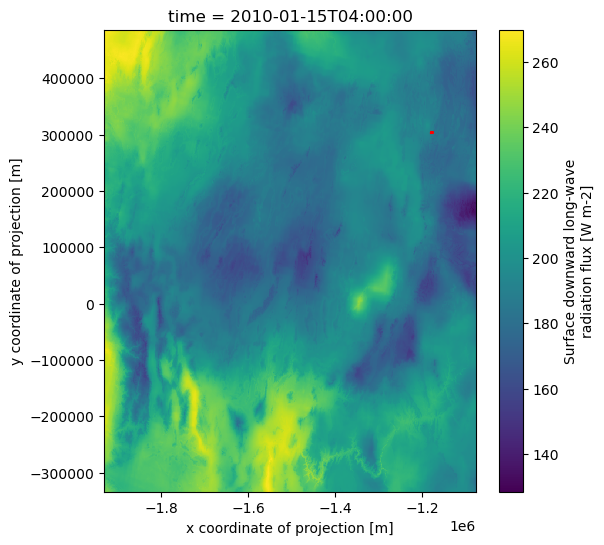

In [353]:
from rasterio.plot import show
from matplotlib import pyplot

fig, ax = pyplot.subplots(1, figsize=(6, 6))
ds.LWDOWN.isel(time=0).plot(ax=ax)

ax.plot(*poly.envelope.exterior.xy, color='red')
ax.plot(*poly2.envelope.exterior.xy, color='red')

In [360]:
mean_arr= rstats.zonal_stats(poly, nc_arr_vals, affine=affine, stats="mean")

In [361]:
mean_arr

[{'mean': 274.558}]